# Exploratory Analysis of Paul15

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

paul_data = sc.read_h5ad("../data/paul15_processed.h5ad")
paul_data

AnnData object with n_obs × n_vars = 2730 × 999
    obs: 'paul15_clusters', 'n_counts_all', 'dpt_pseudotime', 'clusters'
    var: 'n_counts', 'mean', 'std'
    uns: 'clusters_colors', 'clusters_labels', 'clusters_sizes', 'differentiation_graph', 'differentiation_graph_root', 'diffmap_evals', 'iroot', 'log1p', 'neighbors', 'paga', 'paul15_clusters_colors', 'paul15_clusters_labels', 'paul15_clusters_sizes', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [2]:
human_tf_interaction = pd.read_csv("../data/human_tf_interaction.csv")
human_tf_interaction.head()

,gene_ids,A2M,ABCA1,ABCA3,ABCB1,ABCB11,ABCB4,ABCB8,ABCC1,ABCC2,...,ZNF175,ZNF202,ZNF205,ZNF217,ZNF268,ZNF274,ZNF300,ZNF350,ZNF652,ZNF750
0,AATF,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ABL1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AES,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AHR,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AIP,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
paul_data.to_df().head()
# TODO: how to map gene names of paul15 and TTRUST?

,0910001L09Rik,1100001G20Rik,1110013L07Rik,1190002H23Rik,1300017J02Rik,1500012F01Rik,1700012B09Rik,2010002N04Rik,2210020M01Rik,2210411K11Rik,...,Zfhx3,Zfp579,Zfp945,Zfpm1,Zswim4,Zyx,calp80,mKIAA0569,mKIAA1575,slc43a2
W31105,-0.706890,-0.191412,-0.271936,-0.628109,-0.134597,3.448540,-0.098519,-0.206632,5.233710,-0.606442,...,-0.140608,-0.156768,-0.139391,-0.912826,-0.171019,-0.564611,-0.155307,-0.481546,-0.448825,-0.221684
W31106,0.342223,-0.191412,-0.271936,0.384035,-0.134597,-0.648571,-0.098519,-0.206632,-0.372799,-0.606442,...,-0.140608,-0.156768,-0.139391,-0.912826,-0.171019,-0.564611,-0.155307,1.637004,-0.448825,-0.221684
W31107,0.129046,-0.191412,-0.271936,-0.628109,-0.134597,-0.648571,-0.098519,-0.206632,0.810977,0.398963,...,2.440129,-0.156768,-0.139391,1.072396,-0.171019,-0.564611,-0.155307,1.256738,0.684437,-0.221684
W31108,0.009686,-0.191412,0.999457,1.329721,-0.134597,1.085459,-0.098519,-0.206632,-0.372799,-0.606442,...,-0.140608,-0.156768,-0.139391,-0.912826,-0.171019,-0.564611,-0.155307,-0.481546,-0.448825,-0.221684
W31109,0.061324,-0.191412,-0.271936,0.654882,-0.134597,1.186021,-0.098519,-0.206632,-0.372799,0.317512,...,-0.140608,-0.156768,-0.139391,0.815896,-0.171019,-0.564611,-0.155307,-0.481546,1.354030,-0.221684


In [4]:
from methods import calculate_mean_change_similarity_matrix, create_transition_grn_graph

df_transitions = paul_data.uns["differentiation_graph"]
df_data = paul_data.to_df()
clusters = paul_data.obs["paul15_clusters"]

graph = create_transition_grn_graph(df_transitions, df_data, clusters, calculate_mean_change_similarity_matrix)

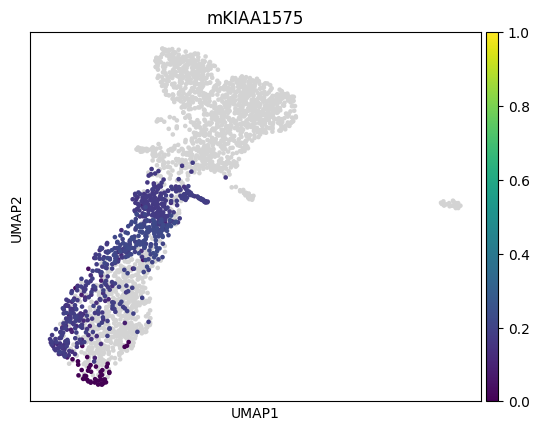

In [5]:
from methods import calculate_cell_activity_scores_along_path
from plotting import plot_cell_activity_score_along_path

path_differentiation = ["8Mk", "7MEP", "6Ery", "3Ery", "1Ery"]
genes = ["mKIAA1575"]

calculate_cell_activity_scores_along_path(paul_data, graph, path_differentiation)
plot_cell_activity_score_along_path(paul_data, genes) 

In [ ]:
from data_utils import extract_samples_of_cell_cluster

def acitivity_dissimilarity_score(histograms):
    """
    Histograms should be normalized.
    """
    num_histograms, _num_genes, _num_bins = histograms.shape

    min_max_distance =  np.max(histograms, axis=0) - np.min(histograms, axis=0) 
    return np.sum(min_max_distance, axis=1) / num_histograms


def calculate_activity_dissimilarity_across_path(adata, num_bins: int = 64):
    path = adata.uns["path_differentiation"]
    clusters = adata.obs["clusters"]
    activity_scores = adata.to_df(layer="activity_score")

    histograms = np.zeros((len(path) - 1, adata.n_vars, num_bins))

    for i, node in enumerate(path[:-1]):
        cluster = extract_samples_of_cell_cluster(activity_scores, clusters, node)
        for j, gene in enumerate(adata.var_names):
            gene_activity_scores = cluster.loc[:, gene].values
            hist, _bin_edges = np.histogram(gene_activity_scores, bins=num_bins, range=(0., 1.), density=True)
            histograms[i, j, :] = hist

    adata.var["activity_dissimilarity"] = acitivity_dissimilarity_score(histograms)


Thy1       63.668897
Map4k3     62.564970
S100a9     62.332252
S100a6     61.922525
Lmcd1      61.890126
Rnf180     59.852061
Cox6a2     59.730775
Cd300lg    59.400160
Name: activity_dissimilarity, dtype: float64

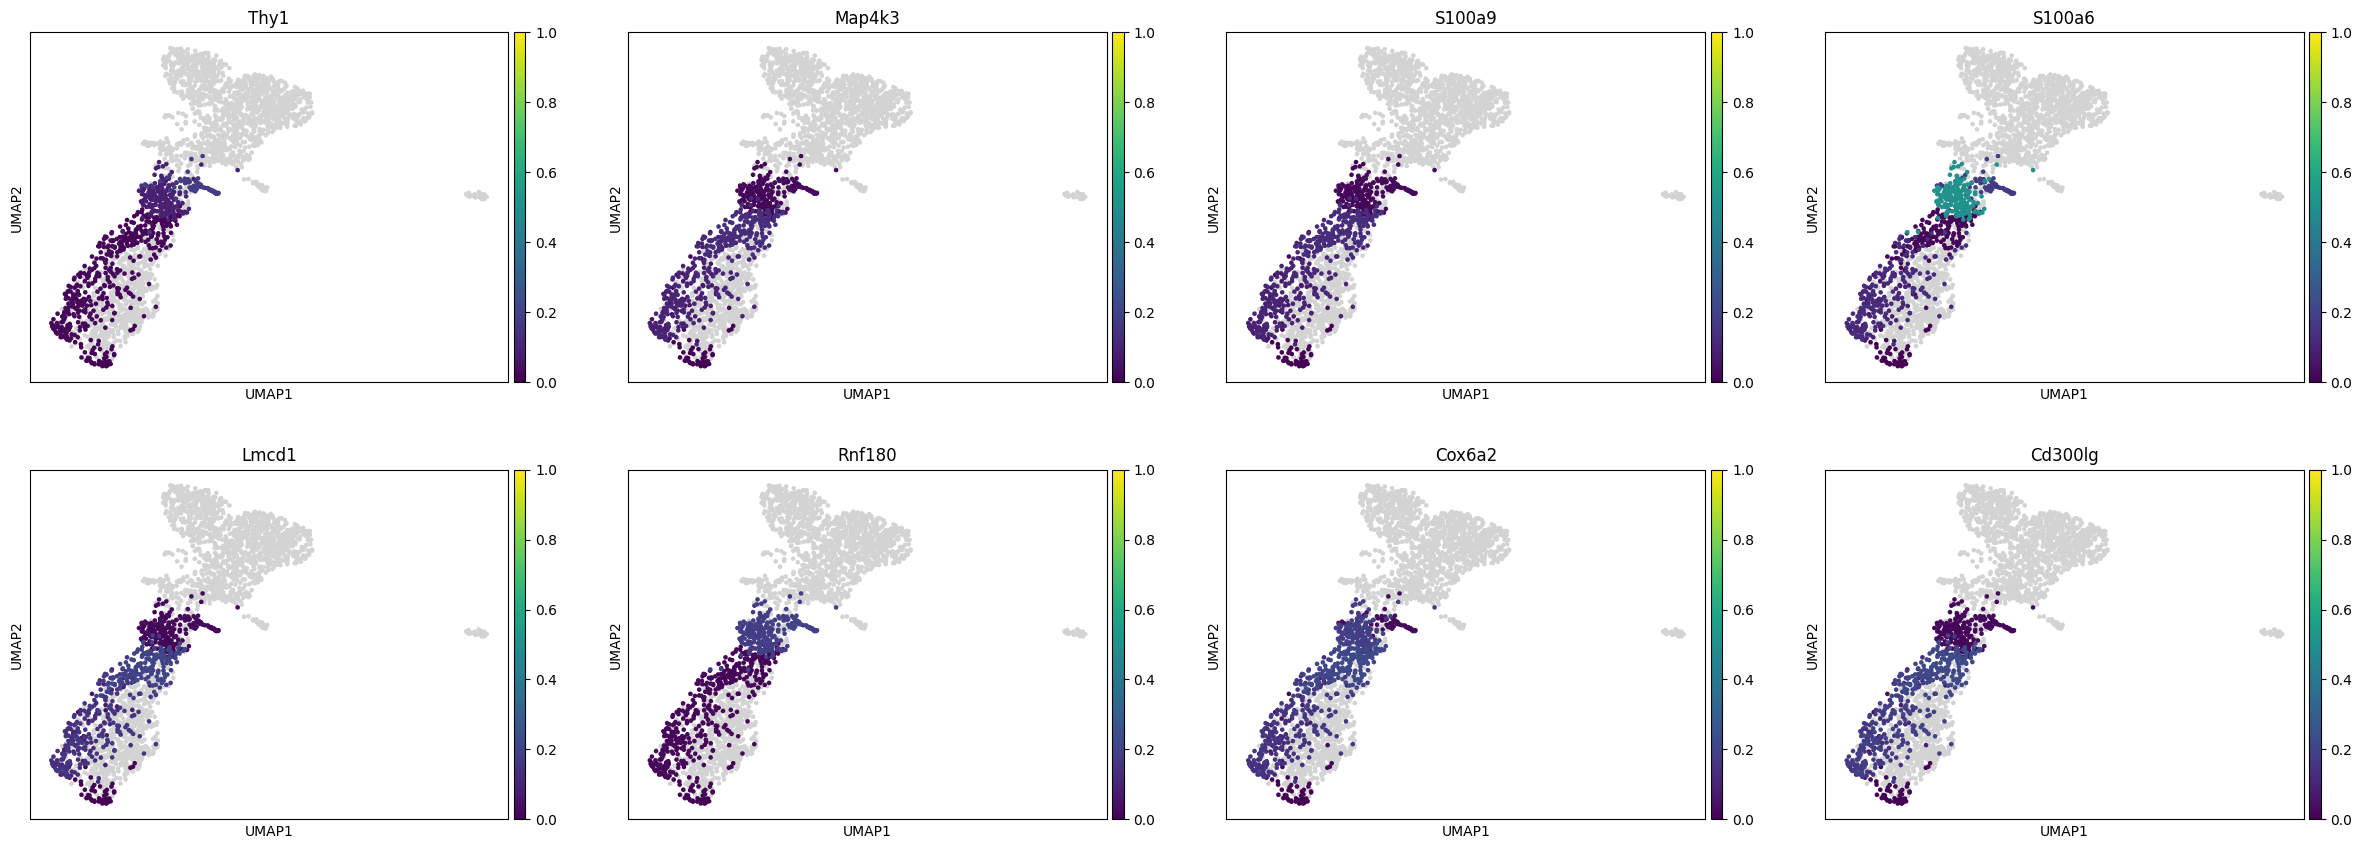

In [11]:
calculate_activity_dissimilarity_across_path(paul_data)

num_top_genes = 8
top_genes = paul_data.var["activity_dissimilarity"].nlargest(num_top_genes)

display(top_genes)

genes = top_genes.index
plot_cell_activity_score_along_path(paul_data, genes) 